## 0. Imports, Paths and Helper Functions

### 0.1 Imports

In [1]:
import json
import psycopg2
import itertools
import pickle


import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

import scikitplot as skplt
import sklearn.model_selection as ms

from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler,MinMaxScaler
from sklearn.tree          import DecisionTreeClassifier, ExtraTreeClassifier

from scipy                 import stats        as ss
from sklearn               import neighbors    as nh
from sklearn               import linear_model as lm


### 0.2 Paths

In [2]:
data = '../data/'
raw  = 'raw/'
interim = 'interim/'
processed = 'processed/'

modules_path = '../models/'

images_path = '../reports/figures/'

### 0.3 Helper Functions

In [3]:
def cross_validation(kfold, at_k, model, data,target,cols_selected):
    
    folds = ms.StratifiedKFold(n_splits=kfold,shuffle=True,random_state=42)
    
    precision = []
    recall = []
    
    for train_index, test_index in folds.split(data,data[target]):
        
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        
        #train and test model - return model probas
        yhat_model = model_evaluation(train,test,model,cols_selected,target)
        
        df_score = test.copy()
        df_score['score'] = yhat_model[:,1].tolist()
        df_score = df_score.sort_values('score',ascending=False)
        
        precision_model = precision_at_k(df_score,at_k)
        recall_model = recall_at_k(df_score,at_k)
        
        precision.append(precision_model)
        recall.append(recall_model)

    mean_p = np.mean(precision)
    std_p = np.std(precision)
    
    mean_r = np.mean(recall)
    std_r = np.std(recall)
    
    return mean_p, std_p, mean_r, std_r


def precision_at_k(data, k=5000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index+1

    #computing precision at k score
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
    precision_at_k = data.loc[k,'precision_at_k']
    
    return precision_at_k


def recall_at_k(data, k=5000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index+1

    #computing recall at k score
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
    recall_at_k = data.loc[k,'recall_at_k']
    
    return recall_at_k


def model_evaluation(train,test,model,cols_selected,target):
    x_train = train[cols_selected]
    y_train = train[target]
    
    x_test = test[cols_selected]
    
    model.fit(x_train,y_train)
    
    yhat_model = model.predict_proba(x_test)
    
    return yhat_model

def gmc(y_true,y_probas, model_name):
    figs,ax = plt.subplots(ncols=3,figsize=(20,5))
    
    skplt.metrics.plot_roc(y_true,y_probas, ax=ax[0],title=f"ROC - {model_name}")
    skplt.metrics.plot_cumulative_gain(y_true,y_probas, ax=ax[1],title=f"Cumulative Gain - {model_name}")
    skplt.metrics.plot_lift_curve(y_true,y_probas, ax=ax[2],title=f"Lift Curve - {model_name}")
    
    plt.show()


def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v


def categorical_feature_correlation(df_cat):
    cat_list = df_cat.columns.to_list()
    dic_corr = {cat : [] for cat in cat_list}
    
    for a,b in itertools.product(cat_list,repeat=2):
        dic_corr[a].append(cramer_v(df_cat[a],df_cat[b]))

    return pd.DataFrame(dic_corr,index=cat_list)


def cat_info(ax,total,size = 25,file=False):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(height/total*100),
                ha="center",size=size) 
    plt.show()
    
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 7.0 Machine Learning Models

In [5]:
selected_cols = ['vintage',
                 'annual_premium',
                 'age',
                 'vehicle_damage',
                 'region_code',
                 'policy_sales_channel']

In [6]:
train = pd.read_csv(data+processed+'train_processed.csv')
x_train = train[selected_cols]
y_train = train['response']

validation = pd.read_csv(data+processed+'validation_processed.csv')
x_val = validation[selected_cols]
y_val = validation['response']

### 7.1 - KNN

In [7]:
knn_model = nh.KNeighborsClassifier(n_neighbors=8, weights='distance')


yhat_knn = model_evaluation(train,validation,knn_model,selected_cols,'response')

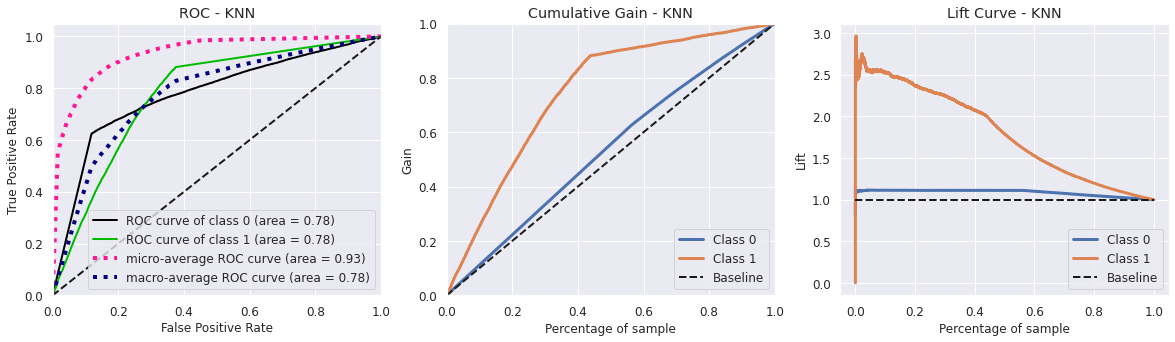

In [8]:
gmc(y_val,yhat_knn,'KNN')

### 7.2 Logistic Regression

In [9]:
lr_model = lm.LogisticRegression(random_state = 42)

yhat_lr = model_evaluation(train,validation,lr_model,selected_cols,'response')

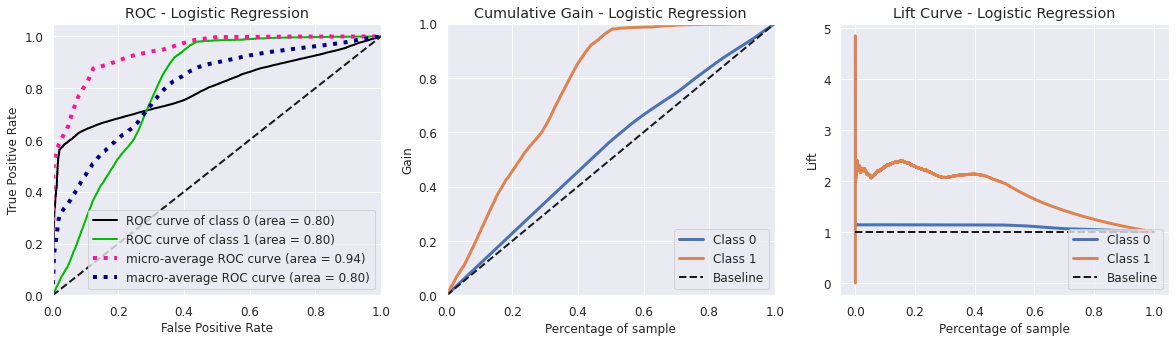

In [10]:
gmc(y_val,yhat_lr,'Logistic Regression')

### 7.3 Random Forest

In [11]:
rf_model = RandomForestClassifier(n_estimators= 250, random_state=42)

yhat_rf = model_evaluation(train,validation,rf_model,selected_cols,'response')

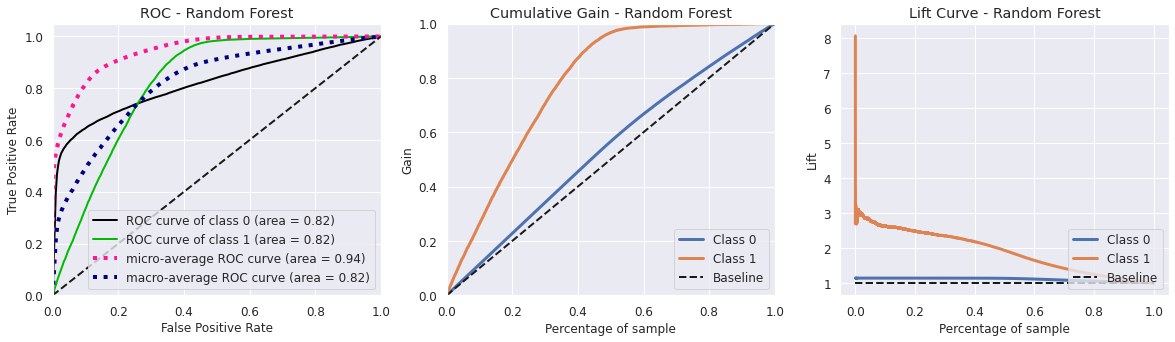

In [12]:
gmc(y_val,yhat_rf,'Random Forest')

### 7.4 Decision Tree

In [13]:
dtc_model = DecisionTreeClassifier()

yhat_dtc = model_evaluation(train,validation,dtc_model,selected_cols,'response')

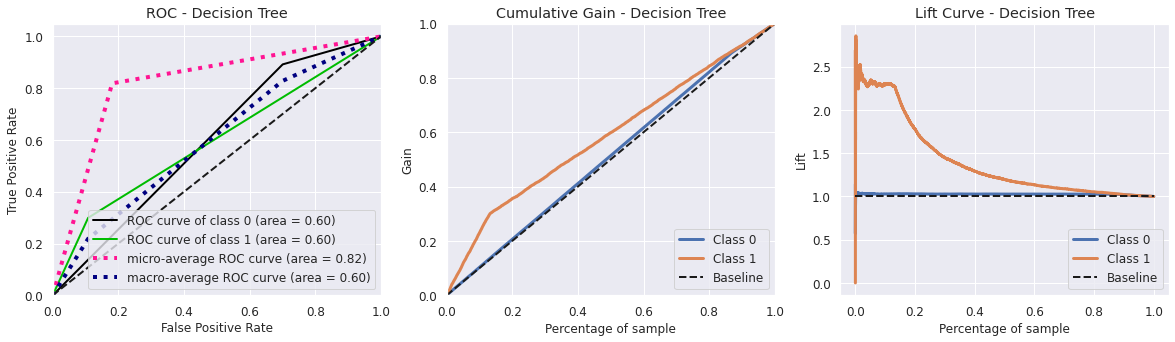

In [14]:
gmc(y_val,yhat_dtc,'Decision Tree')

### 7.5 Extra Trees

In [15]:
#etc_model = ExtraTreesClassifier(random_state=42)

#yhat_etc = model_evaluation(train,validation,etc_model,selected_cols,'response')

In [16]:
#gmc(y_val,yhat_etc,'Extra Trees')

### 7.6 ADABoost 

In [17]:
ab_model = AdaBoostClassifier(random_state=42)


yhat_ab = model_evaluation(train,validation,ab_model,selected_cols,'response')

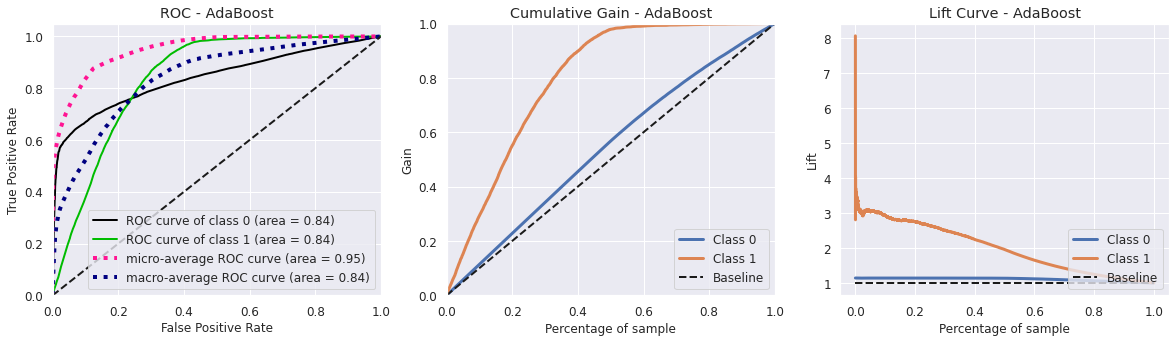

In [18]:
gmc(y_val,yhat_ab,'AdaBoost')

### 7.7 Cross Validation Metrics

In [19]:
knn_model = nh.KNeighborsClassifier(n_neighbors=8, weights='distance')
lr_model  = lm.LogisticRegression(random_state = 42)
rf_model  = RandomForestClassifier(n_estimators= 250, random_state=42)
dtc_model = DecisionTreeClassifier()
#etc_model = ExtraTreesClassifier(random_state=42)
ab_model  = AdaBoostClassifier(random_state=42)

models_dict = {'KNN': knn_model,
              'Logistic_Regression': lr_model,
              'Random_Forest': rf_model,
              'Decision Tree': dtc_model,
#              'Extra Trees':etc_model,
              'AdaBoost':ab_model}


In [20]:
cv_dict = {'Mean Precision @k':[], 'STD Precision @k':[], 'Mean Recall @k': [], 'STD Recall @k':[]}
indexes = []

kfold = 5
at_k = 10000

for name, model in models_dict.items():
    
    print(f'Cross validation for model: {name}')
    model_metric = list(cross_validation(kfold,at_k,model,train,'response',selected_cols))
    
    indexes.append(name)
    cv_dict['Mean Precision @k'].append(model_metric[0])
    cv_dict['STD Precision @k'].append(model_metric[1])
    cv_dict['Mean Recall @k'].append(model_metric[2])
    cv_dict['STD Recall @k'].append(model_metric[3])

result = pd.DataFrame(cv_dict,index=indexes)
result

Cross validation for model: KNN
Cross validation for model: Logistic_Regression
Cross validation for model: Random_Forest
Cross validation for model: Decision Tree
Cross validation for model: AdaBoost


,Mean Precision @k,STD Precision @k,Mean Recall @k,STD Recall @k
KNN,0.288991,0.003671,0.484575,0.006160
Logistic_Regression,0.274813,0.003380,0.460801,0.005694
Random_Forest,0.307949,0.001350,0.516364,0.002288
Decision Tree,0.214739,0.001484,0.360070,0.002501
AdaBoost,0.334947,0.003162,0.561633,0.005326


**Chosen: AdaBoost (56.16% Recall)**

## 8.0 Hyperparameter Fine Tunning

In [ ]:
params_dict = {
                'n_estimators':[50,100,200,1000],
                'learning_rate':[0.1,0.5,1],
                'base_estimator__max_depth':[1,5,20],
                'base_estimator__min_samples_leaf':[1,5,10]}

ab_model_tunned = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
hft = ms.RandomizedSearchCV(ab_model_tunned,params_dict,verbose=3,n_iter=30,scoring='recall',random_state=42)

In [49]:
hft.fit(x_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, learning_rate=0.5, n_estimators=100;, score=0.126 total time= 2.9min
[CV 2/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, learning_rate=0.5, n_estimators=100;, score=0.122 total time= 2.7min
[CV 3/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, learning_rate=0.5, n_estimators=100;, score=0.119 total time= 3.0min
[CV 4/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, learning_rate=0.5, n_estimators=100;, score=0.120 total time= 3.1min
[CV 5/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, learning_rate=0.5, n_estimators=100;, score=0.128 total time= 2.9min
[CV 1/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.000 total time=  40.9s
[CV 2/5] END base_estimator__max_depth=1, base_estima

[CV 2/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, learning_rate=0.5, n_estimators=1000;, score=0.140 total time=26.5min
[CV 3/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, learning_rate=0.5, n_estimators=1000;, score=0.131 total time=29.5min
[CV 4/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, learning_rate=0.5, n_estimators=1000;, score=0.132 total time=26.0min
[CV 5/5] END base_estimator__max_depth=20, base_estimator__min_samples_leaf=1, learning_rate=0.5, n_estimators=1000;, score=0.147 total time=25.9min
[CV 1/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.000 total time=  10.1s
[CV 2/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.000 total time=  10.1s
[CV 3/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50

[CV 3/5] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=10, learning_rate=0.5, n_estimators=50;, score=0.009 total time=  33.2s
[CV 4/5] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=10, learning_rate=0.5, n_estimators=50;, score=0.009 total time=  33.1s
[CV 5/5] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=10, learning_rate=0.5, n_estimators=50;, score=0.006 total time=  33.2s
[CV 1/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=10, learning_rate=0.1, n_estimators=200;, score=0.000 total time=  40.3s
[CV 2/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=10, learning_rate=0.1, n_estimators=200;, score=0.000 total time=  40.3s
[CV 3/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=10, learning_rate=0.1, n_estimators=200;, score=0.000 total time=  40.3s
[CV 4/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=10, learning_rate=0.1, n_estimators=200;

[CV 4/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=10, learning_rate=1, n_estimators=100;, score=0.000 total time=  20.1s
[CV 5/5] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=10, learning_rate=1, n_estimators=100;, score=0.000 total time=  20.1s
[CV 1/5] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=5, learning_rate=0.5, n_estimators=1000;, score=0.126 total time=11.0min
[CV 2/5] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=5, learning_rate=0.5, n_estimators=1000;, score=0.131 total time=11.1min
[CV 3/5] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=5, learning_rate=0.5, n_estimators=1000;, score=0.131 total time=11.2min
[CV 4/5] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=5, learning_rate=0.5, n_estimators=1000;, score=0.125 total time=11.3min
[CV 5/5] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=5, learning_rate=0.5, n_estimators=1000;,

RandomizedSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                random_state=42),
                   n_iter=40,
                   param_distributions={'base_estimator__max_depth': [1, 5, 20],
                                        'base_estimator__min_samples_leaf': [1,
                                                                             5,
                                                                             10],
                                        'learning_rate': [0.1, 0.5, 1],
                                        'n_estimators': [50, 100, 200, 1000]},
                   random_state=42, scoring='recall', verbose=3)

In [52]:
hft.best_params_

{'n_estimators': 200,
 'learning_rate': 1,
 'base_estimator__min_samples_leaf': 10,
 'base_estimator__max_depth': 20}

In [55]:
best_params = {'n_estimators': 200,
            'learning_rate': 1,
            'base_estimator__min_samples_leaf': 10,
            'base_estimator__max_depth': 20}

## 9.0 Final Model

In [21]:
ab_tunned_model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(min_samples_leaf=10, max_depth=20),
                                    n_estimators=200, learning_rate=1)

### 9.1 Model Training

In [22]:
kfold = 10
at_k = 20000

tunned_model_metrics = cross_validation(kfold,at_k,ab_tunned_model,train,'response',selected_cols)

In [23]:
a = {'ADABoost':[f'{tunned_model_metrics[0]:.3} +/- {tunned_model_metrics[1]:.4}', f'{tunned_model_metrics[2]:.3} +/- {tunned_model_metrics[3]:.4}']}
pd.DataFrame(a,index=['Precision @k', 'Recall @k'])

,ADABoost
Precision @k,0.148 +/- 0.0002278
Recall @k,0.989 +/- 0.001494


**Saving Model**

In [24]:
pickle.dump(ab_tunned_model,open('../models/ab_model.pkl','wb'))